# Effects of image compression on latent space clustering of medical images

### Data Loading

In [2]:
import os
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")
import kagglehub
import plotly.express as px
!pip install Augmentor

# Download latest version
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")

print("Path to dataset files:", path)

100%|██████████| 786M/786M [00:10<00:00, 77.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nodoubttome/skin-cancer9-classesisic/versions/1


In [2]:
train_dir = f"{path}/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
class_dirs = os.listdir(train_dir)
amount_per_class = {c : 0 for c in class_dirs}
for dir in class_dirs:
  examples = os.listdir(f"{train_dir}/{dir}")
  amount_per_class[dir] = len(examples)

fig = px.bar(x = amount_per_class.keys(),
             y = amount_per_class.values(),
             title="Examples per class")
fig.show()

We keep only the top 4 most common classes to reduce effect of unbalance


In [3]:
import shutil
test_dir = f"{path}/Skin cancer ISIC The International Skin Imaging Collaboration/Test"
classes_to_remove = ["actinic keratosis","dermatofibroma","squamous cell carcinoma","seborrheic keratosis", "vascular lesion"]
for c in classes_to_remove:
  try:
    shutil.rmtree(f"{train_dir}/{c}")
  except:
    print(f"{c} not found in train, not deleted")
  try:
    shutil.rmtree(f"{test_dir}/{c}")
  except:
    print(f"{c} not found in test, not deleted")

In [4]:
train_dir = f"{path}/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
class_dirs = os.listdir(train_dir)
amount_per_class = {c : 0 for c in class_dirs}
for dir in class_dirs:
  examples = os.listdir(f"{train_dir}/{dir}")
  amount_per_class[dir] = len(examples)

keys = list(amount_per_class.keys())
keys.reverse()
values = list(amount_per_class.values())
values.reverse()
fig = px.bar(x = keys,
             y = values,
             title="Examples per class",
             width=2000,
             height=400,
             )
fig.update_layout(
    font=dict(size=20)
)
fig.show()

In [5]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(f"{path}/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path(f"{path}/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f"Amount of Training Images: {image_count_train}")
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f"Amount of Testing Images: {image_count_test}")

Amount of Training Images: 1633
Amount of Testing Images: 64


In [7]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    color_mode='rgb')

Found 1633 files belonging to 4 classes.
Using 1307 files for training.
Found 1633 files belonging to 4 classes.
Using 326 files for validation.
Found 64 files belonging to 4 classes.


In [8]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['basal cell carcinoma', 'melanoma', 'nevus', 'pigmented benign keratosis']


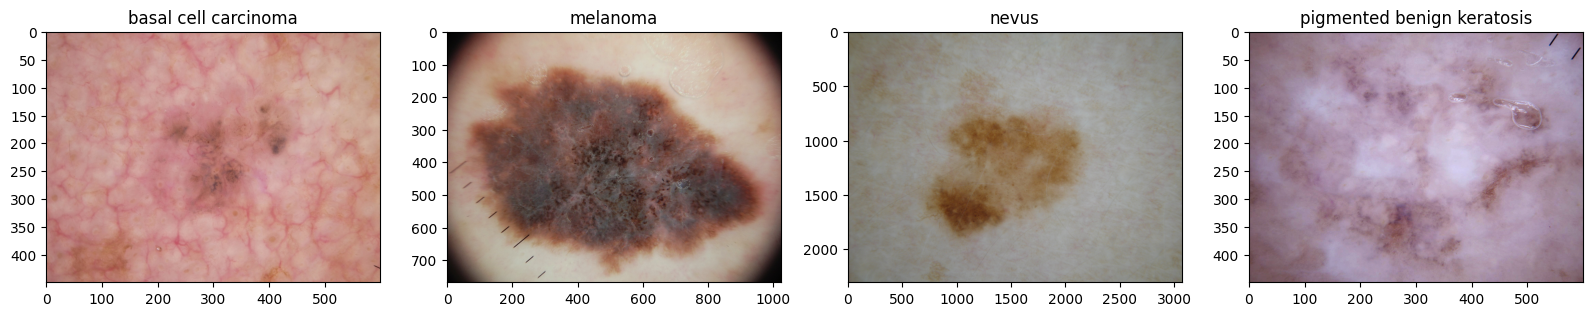

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

### Data Augmentation

In [10]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE # Optimiza automáticamente el batch size para la CPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Augmentor will create 500 augmented samples per class to reduce the degree of class imbalance
import Augmentor

# Define the path to the training dataset
path_to_training_dataset = f'{path}/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
data_dir_train = pathlib.Path(path_to_training_dataset)

# Loop through each class name
for class_name in class_names:
    class_dir = os.path.join(path_to_training_dataset, class_name)

    if os.path.exists(class_dir):
        # Initialize Augmentor pipeline
        output_dir = os.path.join('/kaggle/working/data/', class_name, 'output')  # Use class_name for directory
        os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

        p = Augmentor.Pipeline(source_directory=class_dir, output_directory=output_dir)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(600)  # Generate augmented samples
    else:
        print(f"Directory for class '{class_name}' not found.")

Initialised with 376 image(s) found.
Output directory set to /kaggle/working/data/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BE1EDF7F4F0>: 100%|██████████| 600/600 [00:22<00:00, 26.50 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/data/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x542 at 0x7BE1E840BE20>: 100%|██████████| 600/600 [01:44<00:00,  5.72 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/data/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7BE1EDE32B60>: 100%|██████████| 600/600 [01:30<00:00,  6.62 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/data/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BE1ED9EA7D0>: 100%|██████████| 600/600 [00:19<00:00, 30.70 Samples/s]


In [11]:
import pathlib

data_dir_train = pathlib.Path('/kaggle/working/data/')
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train,'*/output/*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*/output/*.jpg'))]

dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

# We reaccess the now augmented data on the new data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

2400
Found 2400 files belonging to 4 classes.
Using 1920 files for training.
Found 2400 files belonging to 4 classes.
Using 480 files for validation.


In [12]:
# Transformations for Hypervectors
hypervec_size = 500
n_classes = 4

np.random.seed(0)
label_to_vec = {i: np.random.randint(0, 2, (hypervec_size,)) for i in range(n_classes)}

# Check for random vector assignment
first_10 = np.array(label_to_vec[0][0:10])
expected = np.array([0,1,1,0,1,1,1,1,1,1])
assert sum(first_10 - expected) == 0, "Random Vector Assignment is Incorrect"

vec_to_label = {tuple(vec): label for label, vec in label_to_vec.items()}
label_to_name = {i: name for i, name in enumerate(class_names)}

def transformed_dataset_target(dataset):
    def generator():
        for example, label in dataset:
            input_batch = example.numpy()
            target_batch = label.numpy()
            transformed_targets = [label_to_vec[t] for t in target_batch]
            yield tf.convert_to_tensor(input_batch, dtype=tf.float32), tf.convert_to_tensor(transformed_targets, dtype=tf.int8)

    # Define dataset shapes and types explicitly
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, *dataset.element_spec[0].shape[1:]), dtype=tf.float32),  # Example shape
            tf.TensorSpec(shape=(None, hypervec_size), dtype=tf.int8)  # Target shape
        )
    )

# Transform training and validation datasets
train_ds_transformed = transformed_dataset_target(train_ds)
val_ds_transformed = transformed_dataset_target(val_ds)


In [25]:
#Data Augmentation Layer for CNN
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Added later
# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
# End of Added Later

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(1000,activation='sigmoid'))
model.add(layers.Dense(hypervec_size,activation='sigmoid'))

# Compiling the model
model.compile(optimizer='adamW',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 45, 45, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1000)                │      15,489,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 500)                 │         500,500 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,139,004 (61.57 MB)

 Trainable params: 16,139,004 (61.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model
earlyStopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

epochs = 50
history = model.fit(
  train_ds_transformed,
  validation_data=val_ds_transformed,
  epochs=epochs,
  callbacks=earlyStopping
)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - loss: 0.3241 - mse: 0.2639 - val_loss: 0.2932 - val_mse: 0.2909
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - loss: 0.2879 - mse: 0.2861 - val_loss: 0.2932 - val_mse: 0.2922
Epoch 3/50
21/60 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - loss: 0.2790 - mse: 0.2781

In [ ]:
model.save("best_model.keras")

In [ ]:
# Download trained model from gdrive
#!gdown 1xSHKnHnXC2UTStn3PtQTQbxCskfg-uGl

Downloading...
From (original): https://drive.google.com/uc?id=1xSHKnHnXC2UTStn3PtQTQbxCskfg-uGl
From (redirected): https://drive.google.com/uc?id=1xSHKnHnXC2UTStn3PtQTQbxCskfg-uGl&confirm=t&uuid=a11d4f95-f2a6-4d0e-b52e-715d3371b5c0
To: /content/best_model.keras
100% 3.12G/3.12G [00:58<00:00, 53.0MB/s]


In [ ]:
import keras
model2 = tf.keras.models.load_model('best_model.keras')

### Clustering of training examples in latent space

In [1]:
from sklearn.manifold import TSNE

def get_preds_and_targets(ds):
  preds = []
  targets = []
  for batch,batch_targets in ds:
    batch_preds = model.predict(batch)
    for i,p in enumerate(batch_preds):
      preds.append(p)
      targets.append(batch_targets[i])
  return np.array(preds), np.array(targets)

import os
import sys
from PIL import Image

def compress_images(dir, quality):
    assert quality < 95 and quality > 0
    print("Working on quality: ", quality)

    # Creamos directorio para imagenes comprimidas
    dirs = os.listdir(dir)
    compressed_dir = f"data_{str(quality)}"
    if (compressed_dir in dirs):
      return

    os.mkdir(f"{dir}/{compressed_dir}")

    # Comprimimos imagenes
    class_dirs = os.listdir(dir + "/data" )
    for cd in class_dirs:
      new_class_dir = f"{dir}/data_{str(quality)}/{cd}/"
      os.mkdir(new_class_dir)
      os.mkdir(f"{new_class_dir}/output")

      imgs_dir = f"{dir}/data/{cd}/output"
      imgs = os.listdir(imgs_dir)
      for img in imgs:
        img_path = f"{imgs_dir}/{img}"
        img_data = Image.open(img_path)
        img_data.save(f"{new_class_dir}/output/{img}",
                    "JPEG",
                    optimize = True,
                    quality = quality)
    return



In [43]:
qualities = [1,3,5,10,20,50]
for q in qualities:
  compress_images("/kaggle/working", q)

Working on quality:  1
Working on quality:  3
Working on quality:  5
Working on quality:  10
Working on quality:  20
Working on quality:  50


We show one image per quality value

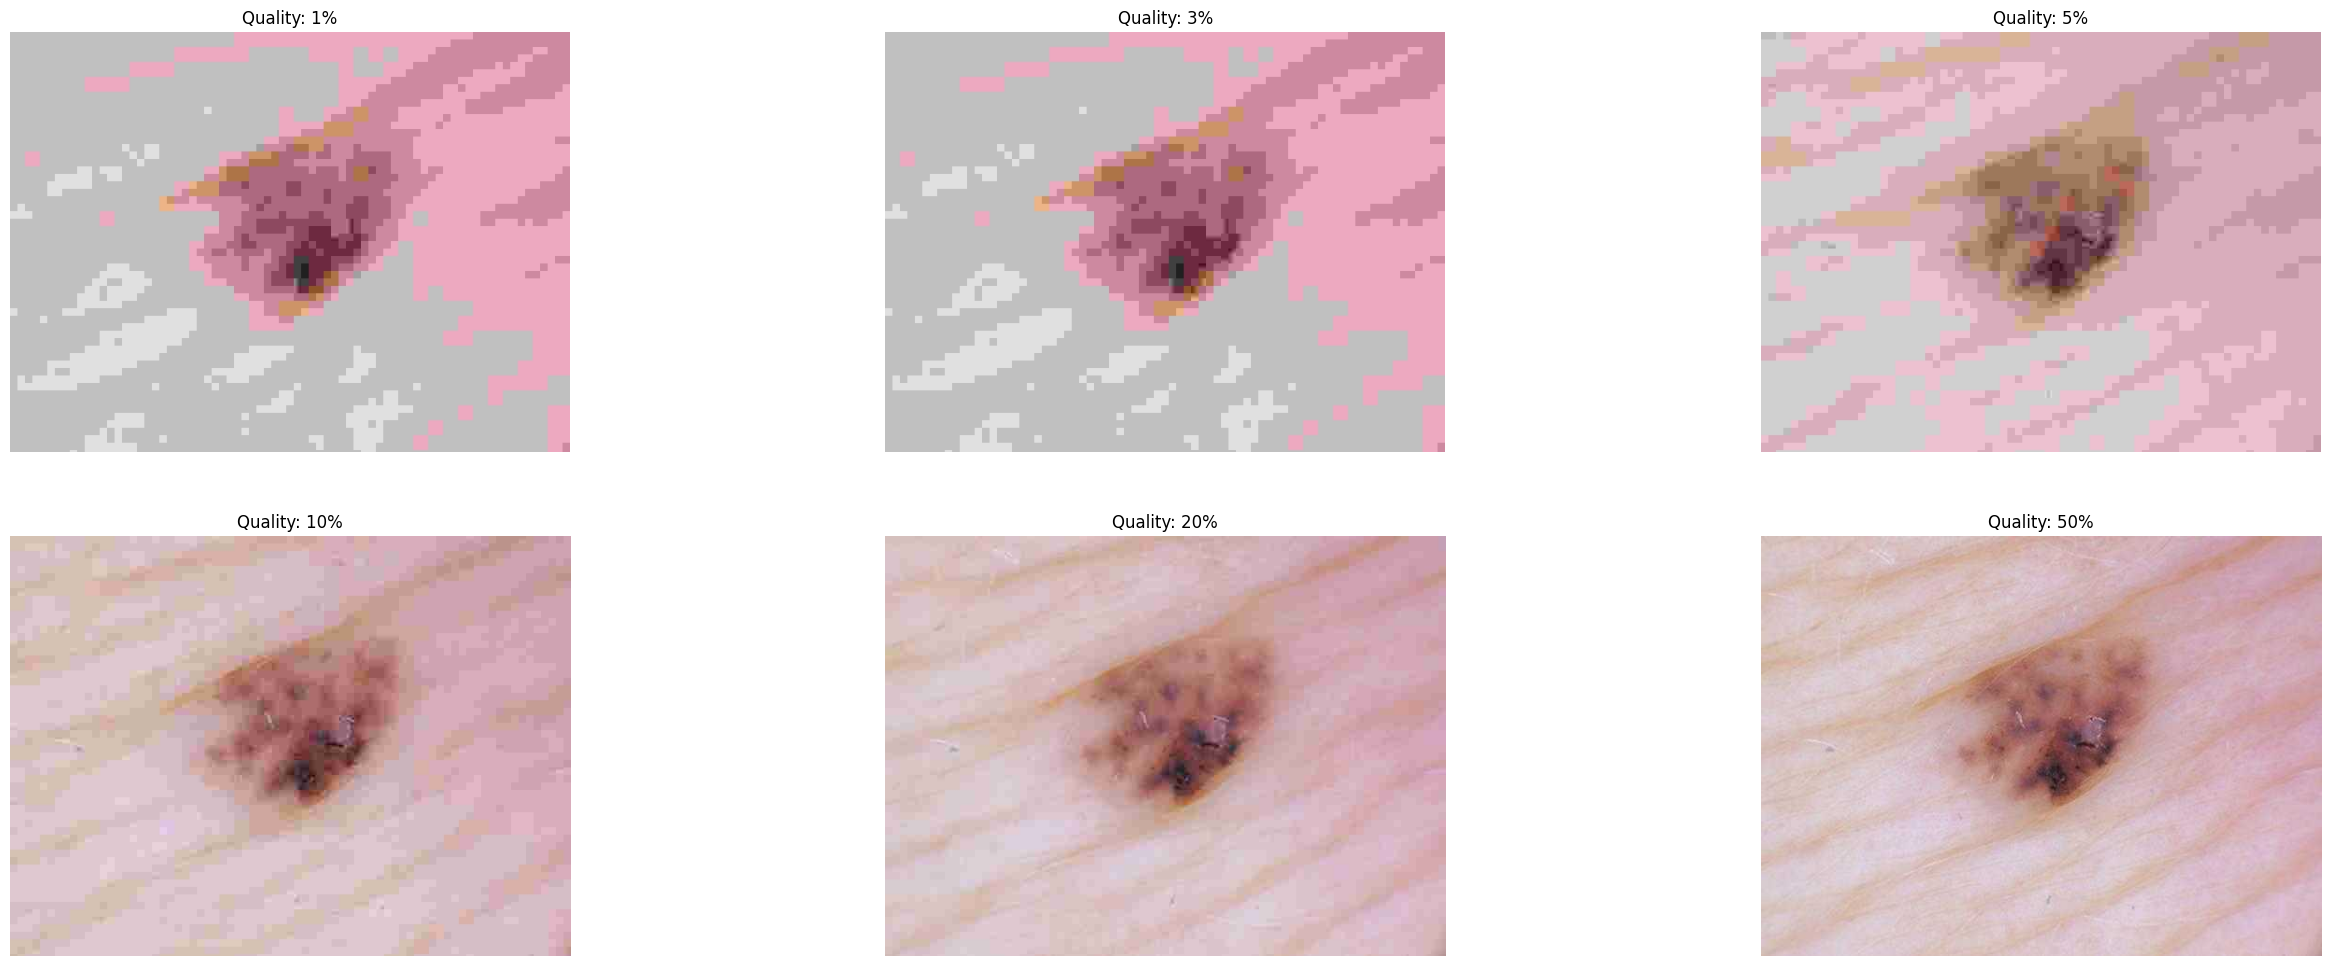

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(32,12))
for i,q in enumerate(qualities):
  # Load the image
  path = f"/kaggle/working/data_{q}/basal cell carcinoma/output/"
  imgs = os.listdir(path)
  image_path = path + imgs[0]   # Replace with your image file path
  img = mpimg.imread(image_path)

  # Display the image

  plt.subplot(2,len(qualities)//2,i+1)
  plt.title(f"Quality: {q}%")
  plt.imshow(img)
  plt.axis('off')  # Hide axes
plt.show()


Accessing compressed files

In [45]:
import pathlib

datasets = {}

for quality in qualities:
  quality = str(quality)

  data_dir_train = pathlib.Path('/kaggle/working/data' + "_" + quality)
  image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
  print(quality, image_count_train)

  from glob import glob
  path_list = [x for x in glob(os.path.join(data_dir_train,'*/output/*.jpg'))]
  lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*/output/*.jpg'))]

  dict_new = dict(zip(path_list, lesion_list_new))
  df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

  # initializing the parameter to load the images
  batch_size = 32
  img_height = 180
  img_width = 180

  # We reaccess the now augmented data on the new data_dir_train
  comp_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = "training",
    image_size=(img_height, img_width),
    batch_size=batch_size)

  comp_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = "validation",
    image_size=(img_height, img_width),
    batch_size=batch_size)

  datasets[int(quality)] = {"train":comp_train_ds, "val":comp_val_ds}

1 2400
Found 2400 files belonging to 4 classes.
Using 1920 files for training.
Found 2400 files belonging to 4 classes.
Using 480 files for validation.
3 2400
Found 2400 files belonging to 4 classes.
Using 1920 files for training.
Found 2400 files belonging to 4 classes.
Using 480 files for validation.
5 2400
Found 2400 files belonging to 4 classes.
Using 1920 files for training.
Found 2400 files belonging to 4 classes.
Using 480 files for validation.
10 2400
Found 2400 files belonging to 4 classes.
Using 1920 files for training.
Found 2400 files belonging to 4 classes.
Using 480 files for validation.
20 2400
Found 2400 files belonging to 4 classes.
Using 1920 files for training.
Found 2400 files belonging to 4 classes.
Using 480 files for validation.
50 2400
Found 2400 files belonging to 4 classes.
Using 1920 files for training.
Found 2400 files belonging to 4 classes.
Using 480 files for validation.


In [46]:
# Transform training and validation datasets
transformed_datasets = {}
for quality, dataset_dict in datasets.items():
  transformed_datasets[int(quality)] = {"train": transformed_dataset_target(dataset_dict["train"]), "val":transformed_dataset_target(dataset_dict["val"])}


### Plotting in latent space

In [47]:
preds_targets_dict = {}
# Uncompressed Latent Space
preds_uncompressed, targets = get_preds_and_targets(train_ds_transformed)
preds_targets_dict["uncompressed"] = {"preds": preds_uncompressed, "targets":targets}

# Compressed Latent Spaces
for quality, dataset_dict in transformed_datasets.items():
  preds_compressed, targets = get_preds_and_targets(dataset_dict["train"])
  preds_targets_dict[quality] = {"preds": preds_compressed, "targets":targets}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [48]:

def plot_latent_space(preds, targets, title):
  plt.figure(figsize=(8, 6))
  # Apply t-SNE
  tsne = TSNE(n_components=2, perplexity=30, random_state=30)
  embedded_data = tsne.fit_transform(np.array(preds))

  # Assign colors to each unique label
  labels = np.array([vec_to_label[tuple(t)] for t in targets])
  unique_labels = list(set(labels))
  colors = plt.cm.get_cmap("tab10", len(unique_labels))  # Choose a colormap
  color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

  # Plot the t-SNE results
  for label in unique_labels:
      indices = [i for i, l in enumerate(labels) if l == label]
      plt.scatter(
          embedded_data[indices, 0],
          embedded_data[indices, 1],
          label=label_to_name[label],
          s=30,
          alpha=0.7,
          color=color_map[label]
      )

  plt.title(title)
  plt.xlabel("t-SNE Component 1")
  plt.ylabel("t-SNE Component 2")
  plt.legend(loc="best")
  plt.plot()
  plt.show()

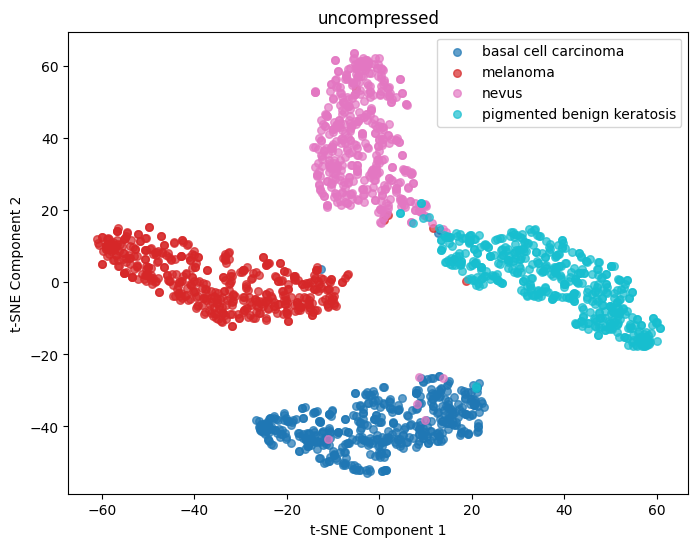

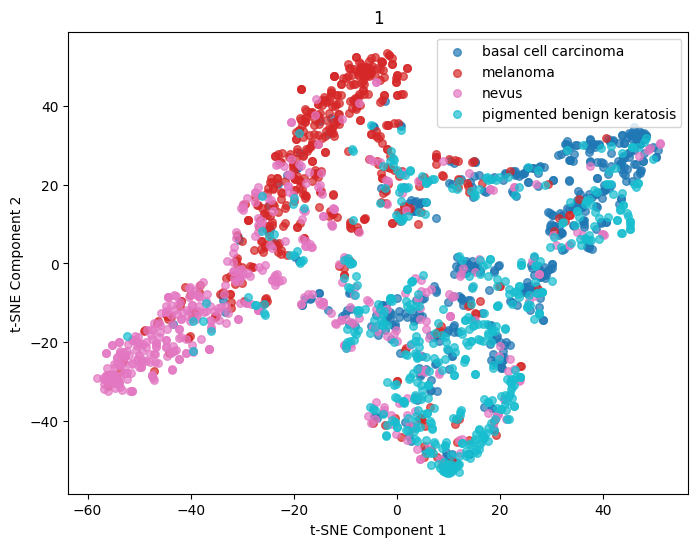

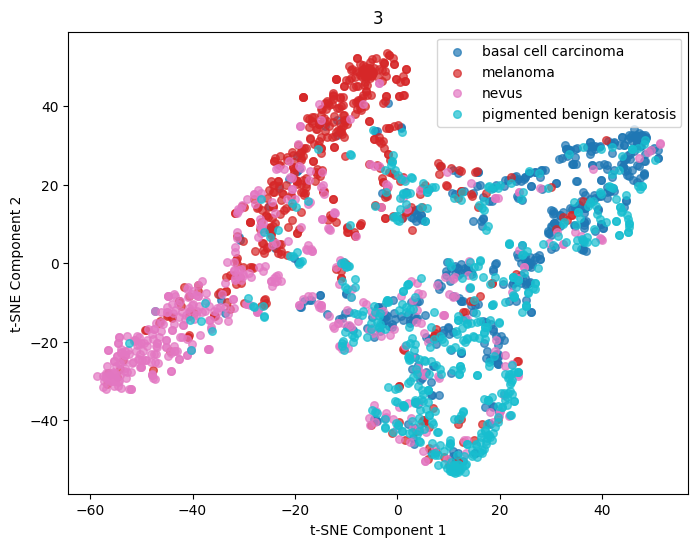

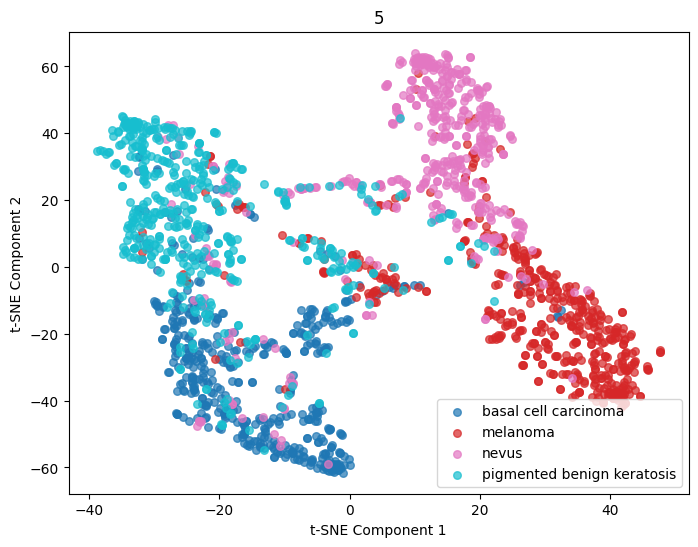

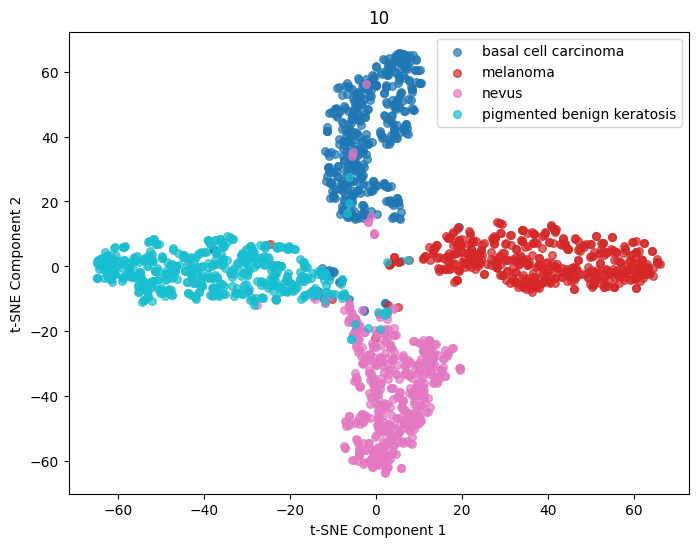

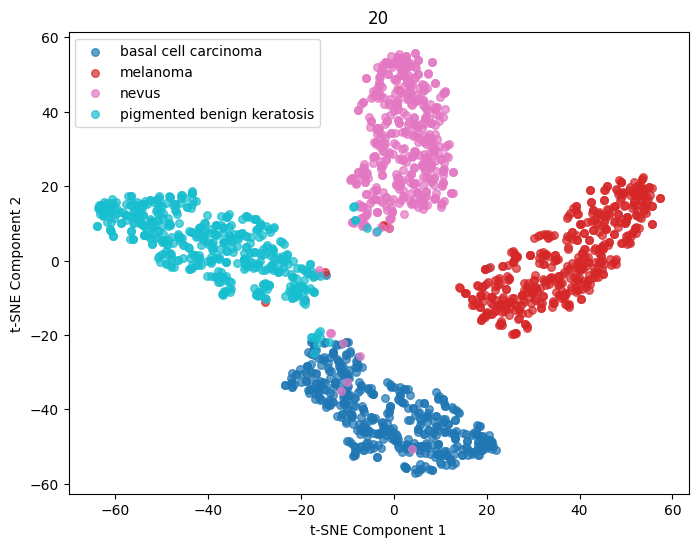

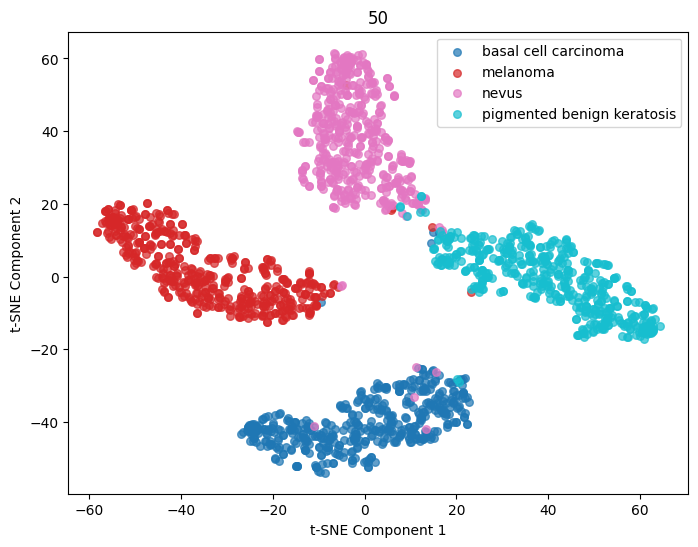

In [49]:
for quality,preds_and_targets in preds_targets_dict.items():
  preds = preds_and_targets["preds"]
  targets = preds_and_targets["targets"]
  plot_latent_space(preds, targets, f"{quality}")

### Measuring classification metrics

In [81]:
from scipy.spatial.distance import cosine

def get_closest_known_vec(vec):
  known_vecs = list(label_to_vec.values())
  known_targets = list(label_to_vec.keys())
  distances = [cosine(vec, known_vec) for known_vec in known_vecs]
  closest_index = np.argmin(distances)
  return known_vecs[closest_index], known_targets[closest_index]

quality_sets = ["uncompressed", 50, 20, 10, 5, 3, 1]
accuracies = []
for q in quality_sets:
  preds = preds_targets_dict[q]["preds"]
  targets = preds_targets_dict[q]["targets"]

  corrects = 0
  for pred,target in zip(preds,targets):
    closest_known_vec, closest_known_target = get_closest_known_vec(pred)
    if closest_known_target == vec_to_label[tuple(target)]:
      corrects += 1
  corrects /= len(preds)
  accuracies.append((str(q) if q != "uncompressed" else "100",round(corrects,3)))
accuracies

[('100', 0.986),
 ('50', 0.986),
 ('20', 0.983),
 ('10', 0.958),
 ('5', 0.803),
 ('3', 0.615),
 ('1', 0.615)]

In [85]:

import plotly.graph_objects as go

fig = go.Figure()

# Add the line plot
fig.add_trace(go.Scatter(x=[a[0] for a in accuracies], y=[a[1] for a in accuracies], mode='lines+markers', name='Data'))

# Customize layout
fig.update_layout(
    title="Model Performance vs Compression Quality",
    xaxis_title="Compression Quality",
    yaxis_title="Model Accuracy",
    yaxis=dict(range=[0, 1]),
    template="plotly_white",
    width=600,  # Set figure width
    height=400  # Set figure height
)

# Show plot
fig.show()